# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\praso\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 116000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (116000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(100551, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.68189655172414

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100549, 10)


1    84354
0    16195
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Last time I had licorice like this is when I visited Holland and got hooked on it.
I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.
I suppose we are all creatures of habit. Mine is coffee, lot's of it. I like a well made percolator coffee, but years ago I discovered Tasters Choice. It's my favorite instant, hands down. Just put a teaspoons-worth in a coffee cup of water and nuke it in the microwave for 1:45 (well, in MY micro, anyway). The coffee is strong for some tastes; do you like espresso? Well, not that strong but definitely potent. Amazon sells it at ab

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Last time I had licorice like this is when I visited Holland and got hooked on it.
I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.
I suppose we are all creatures of habit. Mine is coffee, lot's of it. I like a well made percolator coffee, but years ago I discovered Tasters Choice. It's my favorite instant, hands down. Just put a teaspoons-worth in a coffee cup of water and nuke it in the microwave for 1:45 (well, in MY micro, anyway). The coffee is strong for some tastes; do you like espresso? Well, not that strong but definitely potent. Amazon sells it at about the sa

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this item for cooking it is especially good in brownies cakes and just a little bit in hot cocoa is wonderful 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100549/100549 [01:03<00:00, 1573.41it/s]


In [0]:
preprocessed_reviews[1500]

'love item cooking especially good brownies cakes little bit hot cocoa wonderful'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
# Similartly you can do preprocessing for review summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = []

for sent in (final['Summary'].values):
    sent = re.sub(r"http\S+", "", sent)     # For removing the url from summary
    sent = BeautifulSoup(sent, 'lxml').get_text()    # For removing tags from summary
    sent = decontracted(sent)    # For contraction of words in summary
    sent = re.sub("\S*\d\S*", "", sent).strip()    # For removing words containing numbers in summary
    sent = re.sub('[^A-Za-z]+', ' ', sent)     # For removing special characters from summary
    
    # reference:  https://gist.github.com/sebleier/554280
    
    sent = ' '.join(s.lower() for s in sent.split() if s.lower() not in stopwords)
    preprocessed_summary.append(sent.strip())

In [0]:
preprocessed_summary[1500]

'instant expresso cooking'

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Splitting the data into train, test and cv

x_train = preprocessed_reviews[0:60000]  # 60k datapoints for train
y_train = final["Score"][0:60000]

x_cv = preprocessed_reviews[60000:80000]   # 20k datapoints for cv
y_cv = final["Score"][60000:80000]

x_test = preprocessed_reviews[80000:100000]   # 20k datapoints for test
y_test = final["Score"][80000:100000]

In [0]:
# Converting the train, test and cv data into BOW vectors

count_vect = CountVectorizer(ngram_range = (1,2)) #in scikit-learn
count_vect.fit(x_train)    # fitting the train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

BOW_train = count_vect.transform(x_train)   # transforming the train data
BOW_cv = count_vect.transform(x_cv)   # transforming the cv data
BOW_test = count_vect.transform(x_test)     # transforming the test data

print("the shape of our train BOW vectorizer ",BOW_train.get_shape())
print("the number of unique words ", BOW_train.get_shape()[1])
print("the shape of our cv BOW vectorizer ",BOW_cv.get_shape())
print("the number of unique words ", BOW_cv.get_shape()[1])
print("the shape of our test BOW vectorizer ",BOW_test.get_shape())
print("the number of unique words ", BOW_test.get_shape()[1])

some feature names  ['aa', 'aa dark', 'aa extra', 'aa kona', 'aa may', 'aa medium', 'aa not', 'aa part', 'aa quality', 'aa really']
the shape of our train BOW vectorizer  (60000, 1058210)
the number of unique words  1058210
the shape of our cv BOW vectorizer  (20000, 1058210)
the number of unique words  1058210
the shape of our test BOW vectorizer  (20000, 1058210)
the number of unique words  1058210


In [0]:
# Applying logistic regression with l1 regularization on BOW
cv_A = []
train_A = []

for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l1',C = c, max_iter=500)
    
    lr.fit(BOW_train, y_train)
    
    cv_prob = lr.predict_proba(BOW_cv)[:,1]
    train_prob = lr.predict_proba(BOW_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_A.append(area_cv)
    train_A.append(area_train)



AUC for k =  0.0001  is 50.000000

AUC for k =  0.001  is 72.364095

AUC for k =  0.01  is 88.305502

AUC for k =  0.1  is 94.432743

AUC for k =  1  is 94.880854

AUC for k =  10  is 94.376913

AUC for k =  100  is 94.358575

AUC for k =  1000  is 94.385103


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
A = np.array(lr.coef_)   # Converting into numpy array
sparsity = 1 - (np.count_nonzero(A)/A.size)   # sparsity = 1 - density of array
print("sparsity on weight vector using L1 regularization",sparsity * float(100))

sparsity on weight vector using L1 regularization 97.0650438003799


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
cv_B = []
train_B = []

for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l2',C = c, max_iter=500)
    
    lr.fit(BOW_train, y_train)
    
    cv_prob = lr.predict_proba(BOW_cv)[:,1]
    train_prob = lr.predict_proba(BOW_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for C = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_B.append(area_cv)
    train_B.append(area_train)


AUC for C =  0.0001  is 75.555213

AUC for C =  0.001  is 90.358639

AUC for C =  0.01  is 94.079772

AUC for C =  0.1  is 95.291165

AUC for C =  1  is 95.362195

AUC for C =  10  is 95.242140

AUC for C =  100  is 95.009291

AUC for C =  1000  is 94.797325


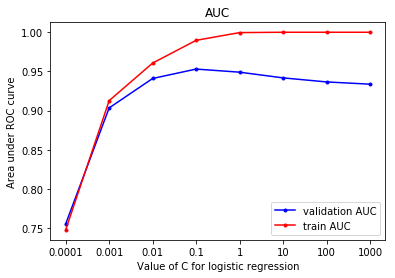

In [0]:
# Plotting AUC for different value of Hyperparameter "C" for train and cv data

k_range = range(0,8)
a = (10**p for p in range(-4,4))
plt.plot( k_range, cv_B,'b',label = "validation AUC",marker = '.')
plt.plot(k_range ,train_B,'r',label = "train AUC",marker = '.')
plt.xlabel('Value of C for logistic regression')
plt.ylabel('Area under ROC curve')
plt.xticks(k_range, a)
plt.title('AUC')
plt.legend()

In [0]:
# Fitting the model with hyperparameter giving highest auc value

lr = LogisticRegression(penalty = 'l2',C = 1, max_iter=500)
    
lr.fit(BOW_train, y_train)
    
test_prob = lr.predict_proba(BOW_test)
train_prob = lr.predict_proba(BOW_train)

test_pred = np.argmax(test_prob, axis=1)   # from stack overflow
train_pred = np.argmax(train_prob, axis=1)   # from stack overflow

# Computing the fpr and tpr
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, test_prob[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, train_prob[:,1])

In [0]:
# Area under ROC curve for training data
area_train = roc_auc_score(y_train, train_prob[:,1]) 
print(area_train)

0.9969983186344518


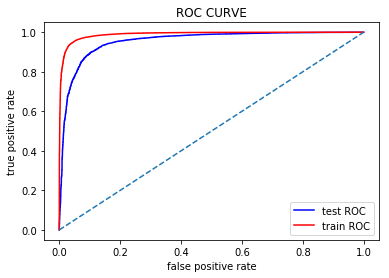

In [0]:
# Plotting ROC curve 

plt.title("ROC CURVE")
plt.plot(fpr1, tpr1, "b", label = "test ROC")
plt.plot(fpr2, tpr2, "r", label = "train ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.legend()
plt.show()

In [0]:
# Confusion matrix
con_test = confusion_matrix(y_test, test_pred)
con_train = confusion_matrix(y_train, train_pred)

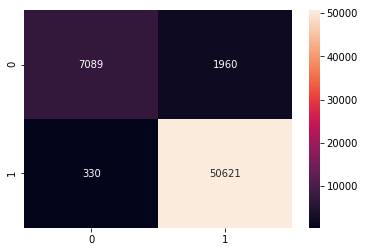

In [0]:
# Confusion matrix in heatmap for train data
hm_train = sns.heatmap(con_train, annot=True, fmt="d")

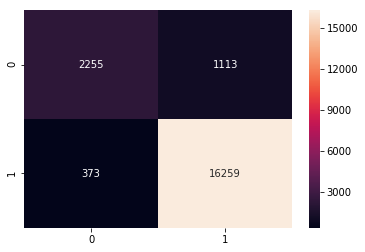

In [0]:
# Confusion matrix in heatmap for test data
hm_test = sns.heatmap(con_test, annot=True, fmt="d")

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
w = lr.coef_   # weight vector
w = w + 10**-6
print(w)

[[-0.08346164  0.02833883 -0.22236673 ...  0.01973047  0.03568025
   0.00996692]]


In [0]:
BOW_train.shape

(60000, 35460)

In [0]:
# Adding noise to the data
noise = np.random.normal(0,0.01,1)
new_train = np.trunc(BOW_train)
new_train.data += noise

In [0]:
new_train.shape

(60000, 35460)

In [0]:
# Training the model again on new_data
lr1 = LogisticRegression(penalty = 'l2',C = 0.1)
    
lr1.fit(new_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
w1 = lr1.coef_   # new_weight vector 
w1 = w1 + 10**-6
print(w1)

[[-0.08320443  0.02845129 -0.22218946 ...  0.01957092  0.03555231
   0.01008472]]


In [0]:
# Percentage change in the weight vector
per_change = ((abs(w - w1))/(w)) * 100

In [0]:
# calculating percentile for any sudden rise in percentage change of weight vector
print(np.percentile(per_change,np.arange(80,101,1)))

[6.56574498e-01 6.86521681e-01 7.19273301e-01 7.56748811e-01
 8.03938465e-01 8.49530733e-01 8.99440524e-01 9.72109144e-01
 1.05242523e+00 1.13766465e+00 1.24432765e+00 1.37917729e+00
 1.54515323e+00 1.73671420e+00 2.00755561e+00 2.43638302e+00
 2.99476099e+00 3.93893131e+00 6.22801306e+00 1.19055310e+01
 2.08791162e+03]


In [0]:
# calculating percentile between 99 and 100
print(np.percentile(per_change,np.arange(99,100.1,0.1)))

[  11.90553103   13.49994267   15.0791911    16.84170375   20.32921251
   23.81422934   29.78816983   40.83513784   58.45486093  109.42177453
 2087.91162428]


In [0]:
per_change=list(per_change[0])

In [0]:
value = []
thres = 58.45486093  # Setting threshold for percentage change
for i in range(0,35460):
    if per_change[i] > thres:
        value.append(per_change.index(per_change[i]))
print(np.take(count_vect.get_feature_names(), value))   # Getting feature names for percentage change greater than threshold             

['able keep' 'actually started' 'always try' 'amazon received'
 'amount caffeine' 'bag going' 'banana nut' 'best energy' 'blackberries'
 'bottle makes' 'caffeine tea' 'cardamom' 'cell' 'chocolate either'
 'coffee comes' 'copy' 'cups per' 'curious' 'dinosaurs' 'enough try'
 'even best' 'everyone tried' 'extended' 'favorite chocolate' 'featuring'
 'food fact' 'frosting' 'garlic powder' 'given dog' 'good feel'
 'got really' 'harvested' 'homegrown' 'imagined' 'like box' 'like chili'
 'long list' 'makes great' 'oat' 'oh gosh' 'one major' 'pack keep'
 'pack not' 'perhaps would' 'picture product' 'pretzels' 'price makes'
 'pure natural' 'reading review' 'recommendation' 'recreate' 'saturated'
 'see anyone' 'seem much' 'sesame chicken' 'short amount' 'stong'
 'strong without' 'take work' 'taste seemed' 'tea writes' 'thought made'
 'time local' 'trust' 'uh' 'upset tummy' 'use love' 'vanilla chocolate'
 'worked fine' 'working well' 'writes box']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
pos_feat = lr.coef_[0,:].argsort()    # computing features of +ve class and sorting them in ascending order 
print(np.take(count_vect.get_feature_names(), pos_feat[-10:]))  # Based on order getting top 10 feature names of +ve class 

['awesome' 'best' 'pleased' 'not bitter' 'wonderful' 'perfect' 'excellent'
 'loves' 'delicious' 'not disappointed']


## [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
neg_feat = lr.coef_[0,:].argsort()   # computing features of +ve class and sorting them in ascending order
print(np.take(count_vect.get_feature_names(), neg_feat[:10]))  # Taking initial 10 features representing top 10 feature names of negative class

['worst' 'awful' 'not worth' 'terrible' 'not good' 'not recommend'
 'disappointing' 'disappointed' 'disappointment' 'never buy']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# 1st
# Splitting the data into train, test and cv

x_train = preprocessed_reviews[0:60000]  # 60k datapoints for train
y_train = final["Score"][0:60000]

x_cv = preprocessed_reviews[60000:80000]   # 20k datapoints for cv
y_cv = final["Score"][60000:80000]

x_test = preprocessed_reviews[80000:100000]   # 20k datapoints for test
y_test = final["Score"][80000:100000]

In [0]:
# 2nd
# Converting the train, test and cv data into tfidf vectors

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 30)
tf_idf_vect.fit(x_train)    # fitting the train data
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidf_train = tf_idf_vect.transform(x_train) # transforming the train data
tfidf_cv = tf_idf_vect.transform(x_cv)     # transforming the cv data
tfidf_test = tf_idf_vect.transform(x_test)    # transforming the test data

print("the shape of our train tfidf vectorizer ",tfidf_train.get_shape())
print("the shape of our cv tfidf vectorizer ",tfidf_cv.get_shape())
print("the shape of our test tfidf vectorizer ",tfidf_test.get_shape())

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able make', 'able order']
the shape of our train tfidf vectorizer  (60000, 11186)
the shape of our cv tfidf vectorizer  (20000, 11186)
the shape of our test tfidf vectorizer  (20000, 11186)


In [0]:
# Applying logistic regression for different value of hyperparameter "C" on tf_idf
cv_C = []
train_C = []

for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l1',C = c)
    
    lr.fit(tfidf_train, y_train)
    
    cv_prob = lr.predict_proba(tfidf_cv)[:,1]
    train_prob = lr.predict_proba(tfidf_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_C.append(area_cv)
    train_C.append(area_train)


AUC for k =  0.0001  is 50.000000

AUC for k =  0.001  is 50.000000

AUC for k =  0.01  is 68.430828

AUC for k =  0.1  is 89.942360

AUC for k =  1  is 95.657266

AUC for k =  10  is 95.595732

AUC for k =  100  is 95.057509

AUC for k =  1000  is 94.896434


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
cv_D = []
train_D = []

for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l2',C = c)
    
    lr.fit(tfidf_train, y_train)
    
    cv_prob = lr.predict_proba(tfidf_cv)[:,1]
    train_prob = lr.predict_proba(tfidf_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_D.append(area_cv)
    train_D.append(area_train)


AUC for k =  0.0001  is 73.410419

AUC for k =  0.001  is 91.470185

AUC for k =  0.01  is 91.464107

AUC for k =  0.1  is 94.091771

AUC for k =  1  is 95.933139

AUC for k =  10  is 95.770517

AUC for k =  100  is 94.159553

AUC for k =  1000  is 92.786063


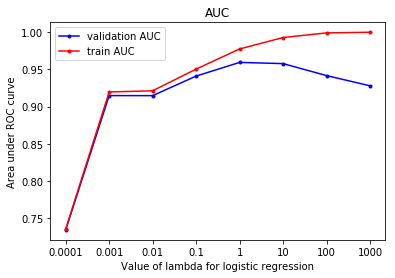

In [0]:
# Plotting AUC for different value of hyperparameter "C" for train and cv data

k_range = range(0,8)
a = (10**p for p in range(-4,4))
plt.plot( k_range, cv_D,'b',label = "validation AUC",marker = '.')
plt.plot(k_range ,train_D,'r',label = "train AUC",marker = '.')
plt.xlabel('Value of lambda for logistic regression')
plt.ylabel('Area under ROC curve')
plt.xticks(k_range, a)
plt.title('AUC')
plt.legend()

In [0]:
# 3rd 
# Fitting the model with hyperparameter giving highest auc value
lr = LogisticRegression(penalty = 'l2',C = 1, max_iter=500)
    
lr.fit(tfidf_train, y_train)
    
test_prob = lr.predict_proba(tfidf_test)
train_prob = lr.predict_proba(tfidf_train)

test_pred = np.argmax(test_prob, axis=1)   # from stack overflow
train_pred = np.argmax(train_prob, axis=1)   # from stack overflow

# Computing the fpr and tpr
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, test_prob[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, train_prob[:,1])

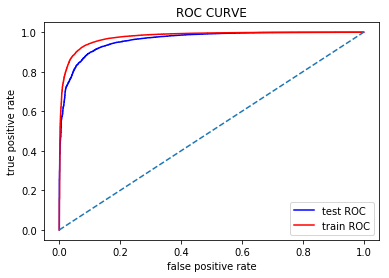

In [0]:
# Plotting ROC curve 

plt.title("ROC CURVE")
plt.plot(fpr1, tpr1, "b", label = "test ROC")
plt.plot(fpr2, tpr2, "r", label = "train ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.legend()
plt.show()

In [0]:
# Confusion matrix
con_test = confusion_matrix(y_test, test_pred)
con_train = confusion_matrix(y_train, train_pred)

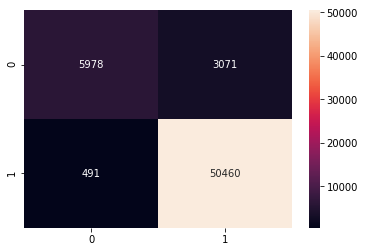

In [0]:
# Confusion matrix in heatmap for train data
hm_train = sns.heatmap(con_train, annot=True, fmt="d")

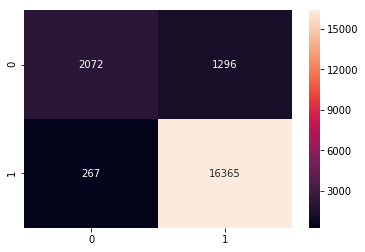

In [0]:
# Confusion matrix in heatmap for test data
hm_test = sns.heatmap(con_test, annot=True, fmt="d")

## [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
pos_feat = lr.coef_[0,:].argsort()    # computing weight vector and sorting them in ascending order 
print(np.take(tf_idf_vect.get_feature_names(), pos_feat[-10:]))  # Based on order getting top 10 feature names of positive class 

['nice' 'wonderful' 'excellent' 'love' 'perfect' 'loves' 'good' 'best'
 'delicious' 'great']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
neg_feat = lr.coef_[0,:].argsort()   # computing weight vector and sorting them in ascending order
print(np.take(tf_idf_vect.get_feature_names(), neg_feat[:10]))  # Taking initial 10 features representing top 10 feature names of negative class

['worst' 'disappointed' 'not' 'awful' 'not good' 'terrible' 'horrible'
 'not worth' 'disappointing' 'not recommend']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# creating the list of lists for each sentence
i=0
list_of_train=[]
list_of_cv=[]
list_of_test=[]
for sentance in x_train:
    list_of_train.append(sentance.split())
    
for sentance in x_cv:
    list_of_cv.append(sentance.split())
    
for sentance in x_test:
    list_of_test.append(sentance.split())

In [0]:
# training our own w2v model using training data

w2v_train = Word2Vec(list_of_train,min_count=50,size=80, workers=4)
print(w2v_train.wv.most_similar('great'))
print('='*100)
print(w2v_train.wv.most_similar('worst'))

w2v_words = list(w2v_train.wv.vocab)

[('fantastic', 0.7708368897438049), ('excellent', 0.7452071905136108), ('awesome', 0.7178908586502075), ('terrific', 0.7095569372177124), ('good', 0.6912645101547241), ('perfect', 0.6765955090522766), ('wonderful', 0.6670398712158203), ('decent', 0.618306577205658), ('nice', 0.5984270572662354), ('amazing', 0.583998441696167)]
[('best', 0.7498338222503662), ('greatest', 0.7238577008247375), ('tastiest', 0.7204858064651489), ('closest', 0.6095279455184937), ('disgusting', 0.599894642829895), ('ive', 0.583441972732544), ('healthiest', 0.5570669174194336), ('experienced', 0.5441569089889526), ('horrible', 0.5258110761642456), ('hardly', 0.5213768482208252)]


In [0]:
# Converting the training data into avg w2v vector

avg_train = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train): # for each review/sentence in train data
    sent_vec = np.zeros(80)
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_train.append(sent_vec)
print(len(avg_train))
print(len(avg_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:03<00:00, 948.27it/s]


60000
80


In [0]:
# Converting the cv data into avg w2v vector

avg_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cv): # for each review/sentence in cv data
    sent_vec = np.zeros(80) 
    cnt_words =0; # num f words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train:
            vec = w2v_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_cv.append(sent_vec)
print(len(avg_cv))
print(len(avg_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 2999.35it/s]


20000
80


In [0]:
# Converting the test data into avg w2v vector

avg_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test): # for each review/sentence in test
    sent_vec = np.zeros(80) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train:
            vec = w2v_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_test.append(sent_vec)
print(len(avg_test))
print(len(avg_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:07<00:00, 2755.14it/s]


20000
80


##  Applying Feature Engineering

In [0]:
# Creating copy of data
import copy

copy_train = copy.deepcopy(avg_train)
copy_cv = copy.deepcopy(avg_cv)
copy_test = copy.deepcopy(avg_test)

In [0]:
# For applying feature engineering using average length of words in review/sentence
# storing average word length of each sentence/review of train, test and cv
len_train = []
len_cv = []
len_test = []

# creating function for computing average word length for each review
def fun(data):
    if len(data) == 0:
        return 0
    else:
        return len(data)/len(data.split())

for sen in x_train:
    len_train.append(fun(sen))
for sen in x_cv:
    len_cv.append(fun(sen))
for sen in x_test:
    len_test.append(fun(sen))

In [0]:
# Adding length of words of each sentence as new feature in BOW vectorizer
from scipy.sparse import csr_matrix
import scipy as sp
new_train = sp.sparse.hstack((copy_train, csr_matrix(len_train).T))   # from stack overflow
new_cv = sp.sparse.hstack((copy_cv, csr_matrix(len_cv).T))
new_test = sp.sparse.hstack((copy_test, csr_matrix(len_test).T))

In [0]:
new_train.shape

(60000, 81)

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
cv_E = []
train_E = []

# Fitting the model for different calue of hyperparameter
for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l1',C = c)
    
    lr.fit(new_train, y_train)
    
    cv_prob = lr.predict_proba(new_cv)[:,1]
    train_prob = lr.predict_proba(new_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_E.append(area_cv)
    train_E.append(area_train)


AUC for k =  0.0001  is 48.835476

AUC for k =  0.001  is 83.174037

AUC for k =  0.01  is 89.840146

AUC for k =  0.1  is 90.723731

AUC for k =  1  is 90.757280

AUC for k =  10  is 90.758352

AUC for k =  100  is 90.758533

AUC for k =  1000  is 90.758516


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
cv_E = []
train_E = []

#fitting the model for different value of hyperparameter
for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l2',C = c)
    
    lr.fit(new_train, y_train)
    
    cv_prob = lr.predict_proba(new_cv)[:,1]
    train_prob = lr.predict_proba(new_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_E.append(area_cv)
    train_E.append(area_train)


AUC for k =  0.0001  is 86.744300

AUC for k =  0.001  is 89.753022

AUC for k =  0.01  is 90.509901

AUC for k =  0.1  is 90.742802

AUC for k =  1  is 90.759500

AUC for k =  10  is 90.759678

AUC for k =  100  is 90.759575

AUC for k =  1000  is 90.759553


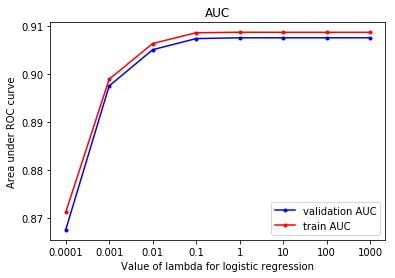

In [0]:
# Plotting AUC for different value of hyperparameter "C" for train and cv data

k_range = range(0,8)
a = (10**p for p in range(-4,4))
plt.plot( k_range, cv_E,'b',label = "validation AUC",marker = '.')
plt.plot(k_range ,train_E,'r',label = "train AUC",marker = '.')
plt.xlabel('Value of lambda for logistic regression')
plt.ylabel('Area under ROC curve')
plt.xticks(k_range, a)
plt.title('AUC')
plt.legend()

In [0]:
# Applying logistic regression for hyperparameter giving highest AUC value
lr = LogisticRegression(penalty = 'l2',C = 10, max_iter=500)
    
lr.fit(new_train, y_train)
    
test_prob = lr.predict_proba(new_test)
train_prob = lr.predict_proba(new_train)

test_pred = np.argmax(test_prob, axis=1)   # from stack overflow
train_pred = np.argmax(train_prob, axis=1)   # from stack overflow

# Computing the fpr and tpr
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, test_prob[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, train_prob[:,1])

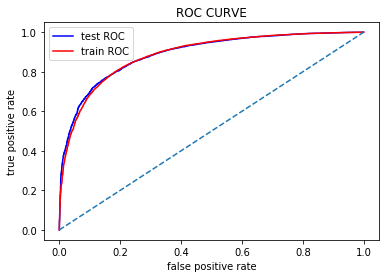

In [0]:
# Plotting ROC curve 

plt.title("ROC CURVE")
plt.plot(fpr1, tpr1, "b", label = "test ROC")
plt.plot(fpr2, tpr2, "r", label = "train ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.legend()
plt.show()

In [0]:
# Confusion matrix
con_test = confusion_matrix(y_test, test_pred)
con_train = confusion_matrix(y_train, train_pred)

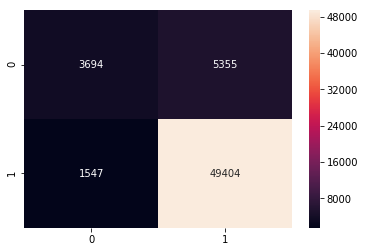

In [0]:
# Confusion matrix in heatmap for train data
hm_train = sns.heatmap(con_train, annot=True, fmt="d")

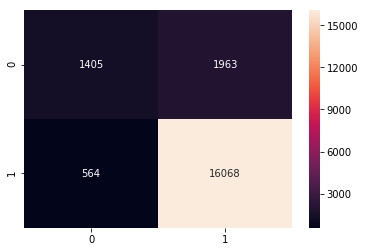

In [0]:
# Confusion matrix in heatmap for test data
hm_test = sns.heatmap(con_test, annot=True, fmt="d")

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Converting the training text data into TFIDF w2v vector
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names

In [0]:
# Converting the training data into TFIDF w2v vector

tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train): # for each review/sentence in train data 
    sent_vec = np.zeros(80) 
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [19:12<00:00, 52.04it/s]


In [0]:
# Converting the cv data into TFIDF w2v vector

tfidf_w2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv): # for each review/sentence in cv data
    sent_vec = np.zeros(80) 
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:20<00:00, 60.88it/s]


In [0]:
# Converting the test data into TFIDF w2v vector

tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test): # for each review/sentence in test data
    sent_vec = np.zeros(80) 
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_train.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:58<00:00, 67.02it/s]


In [0]:
# Creating copy of data
import copy

copy_train = copy.deepcopy(tfidf_w2v_train)
copy_cv = copy.deepcopy(tfidf_w2v_cv)
copy_test = copy.deepcopy(tfidf_w2v_test)

In [0]:
# For applying feature engineering using length of words in summary
# Splitting the summary data into train, test and cv 

sum_train = preprocessed_summary[0:60000]  # 60k datapoints for train
y_train = final["Score"][0:60000]

sum_cv = preprocessed_summary[60000:80000]    # 20k datapoints for cv
y_cv = final["Score"][60000:80000]

sum_test = preprocessed_summary[80000:100000]   # 20k datapoints for test
y_test = final["Score"][80000:100000]

In [0]:
# storing length of words of each summary of train, test and cv
len_train = []
len_cv = []
len_test = []

for sen in sum_train:
    len_train.append(len(sen.split()))
for sen in sum_cv:
    len_cv.append(len(sen.split()))
for sen in sum_test:
    len_test.append(len(sen.split()))

In [0]:
# Adding length of words of each sentence as new feature in BOW vectorizer
from scipy.sparse import csr_matrix
import scipy as sp
new_train = sp.sparse.hstack((copy_train, csr_matrix(len_train).T))   # from stack overflow
new_cv = sp.sparse.hstack((copy_cv, csr_matrix(len_cv).T))
new_test = sp.sparse.hstack((copy_test, csr_matrix(len_test).T))

In [0]:
new_train.shape

(60000, 81)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
cv_F = []
train_F = []

# fitting the model with different value of hyperparameter 
for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l1',C = c)
    
    lr.fit(new_train, y_train)
    
    cv_prob = lr.predict_proba(new_cv)[:,1]
    train_prob = lr.predict_proba(new_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_F.append(area_cv)
    train_F.append(area_train)


AUC for k =  0.0001  is 49.248440

AUC for k =  0.001  is 77.997764

AUC for k =  0.01  is 87.482247

AUC for k =  0.1  is 88.207961

AUC for k =  1  is 88.229262

AUC for k =  10  is 88.229156

AUC for k =  100  is 88.229211

AUC for k =  1000  is 88.229093


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
cv_F = []
train_F = []

#fiiting the model with different value of hyperparameter
for c in (10**p for p in range(-4,4)):
    lr = LogisticRegression(penalty = 'l2',C = c)
    
    lr.fit(new_train, y_train)
    
    cv_prob = lr.predict_proba(new_cv)[:,1]
    train_prob = lr.predict_proba(new_train)[:,1]

    # evaluate AUC for cv and train data
    area_cv = roc_auc_score(y_cv, cv_prob) 
    area_train = roc_auc_score(y_train, train_prob) 
    print('\nAUC for k = ',np.round(c,5),' is %f' % ( area_cv * float(100) ))
    
    cv_F.append(area_cv)
    train_F.append(area_train)


AUC for k =  0.0001  is 71.948909

AUC for k =  0.001  is 86.703212

AUC for k =  0.01  is 88.052948

AUC for k =  0.1  is 88.224654

AUC for k =  1  is 88.229682

AUC for k =  10  is 88.229348

AUC for k =  100  is 88.229260

AUC for k =  1000  is 88.229292


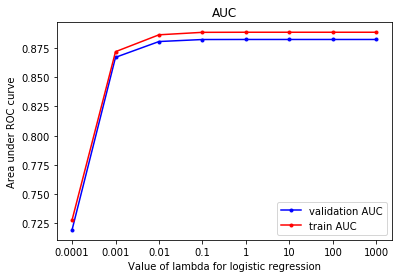

In [0]:
# Plotting AUC for different value of alpha for train and cv data

k_range = range(0,8)
a = (10**p for p in range(-4,4))
plt.plot( k_range, cv_F,'b',label = "validation AUC",marker = '.')
plt.plot(k_range ,train_F,'r',label = "train AUC",marker = '.')
plt.xlabel('Value of lambda for logistic regression')
plt.ylabel('Area under ROC curve')
plt.xticks(k_range, a)
plt.title('AUC')
plt.legend()

In [0]:
# Training the model with hyperparameter giving highest auc value

lr = LogisticRegression(penalty = 'l2',C = 1, max_iter=500)
    
lr.fit(new_train, y_train)
    
test_prob = lr.predict_proba(new_test)
train_prob = lr.predict_proba(new_train)

test_pred = np.argmax(test_prob, axis=1)   # from stack overflow
train_pred = np.argmax(train_prob, axis=1)   # from stack overflow

# Computing the fpr and tpr
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, test_prob[:,1])
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, train_prob[:,1])

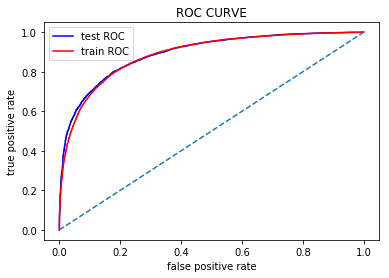

In [0]:
# Plotting ROC curve 

plt.title("ROC CURVE")
plt.plot(fpr1, tpr1, "b", label = "test ROC")
plt.plot(fpr2, tpr2, "r", label = "train ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.legend()
plt.show()

In [0]:
# Confusion matrix
con_test = confusion_matrix(y_test, test_pred)
con_train = confusion_matrix(y_train, train_pred)

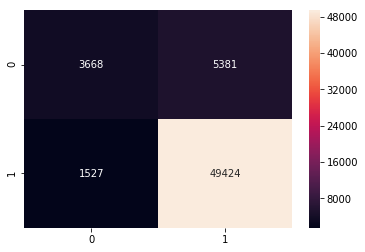

In [0]:
# Confusion matrix in heatmap for train data
hm_train = sns.heatmap(con_train, annot=True, fmt="d")

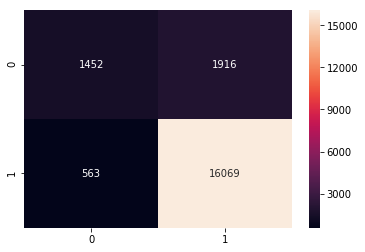

In [0]:
# Confusion matrix in heatmap for test data
hm_test = sns.heatmap(con_test, annot=True, fmt="d")

# [6] Conclusions

In [0]:
from prettytable import PrettyTable

In [0]:
table = PrettyTable()

table.field_names = ["Vectorizer", "model", "Hyper parameter", "AUC"]

table.add_row(["BOW", "logistic regression", 0.1, 0.95])
table.add_row(["TFIDF", "logistic regression", 1, 0.95])
table.add_row(["AVG W2V", "logistic regression", 10, 0.90])
table.add_row(["TFIDF W2V", "logistic regression", 1, 0.88])
print(table)

+------------+---------------------+-----------------+------+
| Vectorizer |        model        | Hyper parameter | AUC  |
+------------+---------------------+-----------------+------+
|    BOW     | logistic regression |       0.1       | 0.95 |
|   TFIDF    | logistic regression |        1        | 0.95 |
|  AVG W2V   | logistic regression |        10       | 0.9  |
| TFIDF W2V  | logistic regression |        1        | 0.88 |
+------------+---------------------+-----------------+------+


##  Testing our model on random review

In [0]:
rev = input("Enter your review : ")

Enter your review : product smells bad


In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_review = []
# tqdm is for printing the status bar

sentance = re.sub(r"http\S+", "", rev)
sentance = BeautifulSoup(sentance, 'lxml').get_text()
sentance = decontracted(sentance)
sentance = re.sub("\S*\d\S*", "", sentance).strip()
sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # This code snippet is from github 
sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
preprocessed_review.append(sentance.strip())

In [0]:
final_count = tf_idf_vect.transform(preprocessed_review)

In [0]:
prob = lr.predict_proba(final_count)
print("Probability of review to be negative is", np.round(prob[0,0] * 100,2) , "%")
print("Probability of review to be positive is", np.round(prob[0,1] * 100,2) , "%")

Probability of review to be negative is 96.74 %
Probability of review to be positive is 3.26 %


In [0]:
pred = lr.predict(final_count)
if pred == 0:
    print("This review is negative ")
else:
    print("This review is positive ")

This review is negative 
